In [1]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = 'd01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])

In [3]:
time_window = 50
time_step = 25
trial_bin_size = 20
n_splits = 30
group_dict = OrderedDict([('1 (very dissimilar)',[11]),('1 (dissimilar)',[12]),('1 (similar)',[13]),('2',[20])])
train_labels = ['1 (very dissimilar)','2']
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=train_labels)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [8]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.group_labels(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, y_train = wrangl.select_training_data(X_train_all, y_train) 
        X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)

        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
        wrangl.ifold+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [9]:
interp = eeg_decoder.Interpreter(clfr, subtitle='hyperplane')
interp.save_results(timestamp=False)

In [4]:
interp = eeg_decoder.Interpreter()
interp.load_results('hyperplane')

Saving output\figures\hyperplane1v2.pdf
Saving output\figures\hyperplane1v2.png


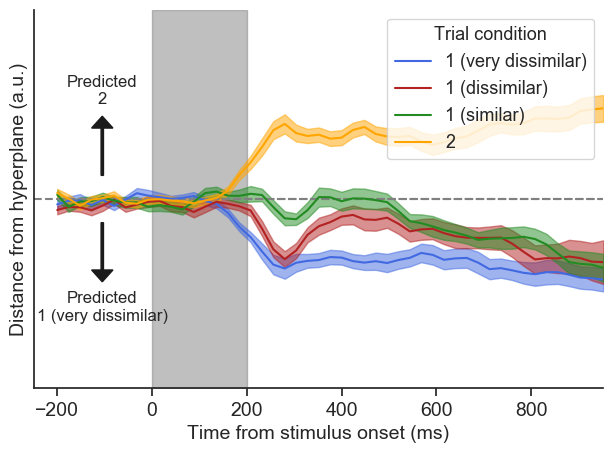

In [24]:
interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-4,4],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5],
    savefig=True,subtitle='1v2',legend_pos='upper right')

In [5]:
import numpy as np
import pandas as pd
def get_condition_means(conf_scores, time_idx=None):

    if time_idx is None:
        delay_acc =np.mean(np.mean(interp.confidence_scores,2),1)
    else:
        delay_acc =np.mean(np.mean(interp.confidence_scores[:,time_idx],2),1)

    subject_means = pd.DataFrame(delay_acc,columns=list(group_dict.keys()))
    labels = list(group_dict.keys())
    subject_means['Subject'] = np.arange(exp.nsub)

    x = subject_means.melt(id_vars='Subject',value_vars=labels,var_name='Condition',value_name='Distance from Hyperplane')
    condition_means = x.groupby('Condition').mean()['Distance from Hyperplane'].to_numpy()
    return x, condition_means

In [6]:

stim_time_idx = (wrangl.t>0)&(wrangl.t<200)
first_half_time_idx = (wrangl.t>200)&(wrangl.t<600)
second_half_time_idx = (wrangl.t>600)
x_0, condition_means_0 = get_condition_means(interp.confidence_scores,stim_time_idx)
x_1, condition_means_1 = get_condition_means(interp.confidence_scores,first_half_time_idx)
x_2, condition_means_2 = get_condition_means(interp.confidence_scores,second_half_time_idx)

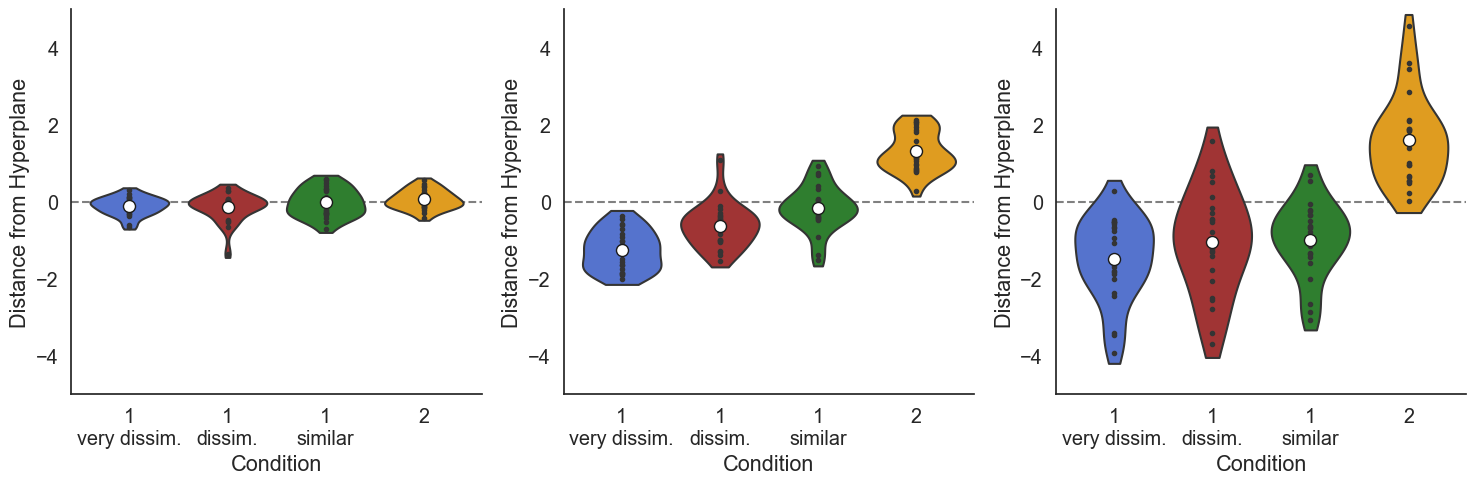

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(font_scale=1.3,style='white',rc=custom_params)

fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].axhline(y=0, color='grey', linestyle='--',zorder=-10)
sns.violinplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_0,ax=ax[0],palette= interp.colors[:4],
    dodge=True,inner='points',cut=.5,scale='width')
ax[0].scatter(
    x = [0,1,2,3],
    y = [condition_means_0[2],condition_means_0[0],condition_means_0[1],condition_means_0[3]],
    c = 'white', edgecolors='k',s=75)
ax[0].set_ylim(-5,5)
ax[0].set_xticklabels(['1\nvery dissim.','1\ndissim.','1\nsimilar','2'])

ax[1].axhline(y=0, color='grey', linestyle='--',zorder=-10)
sns.violinplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_1,ax=ax[1],palette= interp.colors[:4],
    dodge=True,inner='points',cut=.5,scale='width')
ax[1].scatter(
    x = [0,1,2,3],
    y = [condition_means_1[2],condition_means_1[0],condition_means_1[1],condition_means_1[3]],
    c = 'white', edgecolors='k',s=75)
ax[1].set_ylim(-5,5)
ax[1].set_xticklabels(['1\nvery dissim.','1\ndissim.','1\nsimilar','2'])

ax[2].axhline(y=0, color='grey', linestyle='--',zorder=-10)
sns.violinplot(
    x='Condition',y='Distance from Hyperplane', 
    data=x_2,ax=ax[2],palette= interp.colors[:4],
    dodge=True,inner='points',cut=.5,scale='width')
ax[2].scatter(
    x = [0,1,2,3],
    y = [condition_means_2[2],condition_means_2[0],condition_means_2[1],condition_means_2[3]],
    c = 'white', edgecolors='k',s=75)
ax[2].set_ylim(-5,5)
ax[2].set_xticklabels(['1\nvery dissim.','1\ndissim.','1\nsimilar','2'])

plt.savefig('output/figures/hyperplane_violin.png',dpi=500,bbox_inches='tight')
plt.show()